<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/analyze_gluc_trace_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openpyxl
!pip install XlsxWriter
# !pip install pingouin
# !pip install CMH
# !pip install svgutils


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.8 MB/s eta 0:00:00


In [2]:
import tifffile
import numpy as np
from google import colab
from matplotlib import pyplot as plt
import scipy
from tqdm import tqdm
import matplotlib as mpl
import pandas as pd

In [3]:
def get_drobox_file(new_filename, link):
    !wget -o $new_filename $link
    return new_filename


In [4]:
def get_drobox_file(new_filename, link):
    !wget -O $new_filename $link
    return new_filename

link = 'https://www.dropbox.com/s/rm0kd1vl4sg5efg/Glucose%20data%20May2023.xlsx?dl=1'
new_filename = 'data.xlsx'
get_drobox_file(new_filename, link)
my_df_dict  = pd.read_excel('/content/data.xlsx',engine='openpyxl',header=[0,1,2,3],index_col=None,sheet_name=None)

# Trim  blanks
for k,v in my_df_dict.items():
    v=v.drop(0,axis=0).reset_index().drop('index',axis=1)
    for c in v.columns:
        if v[c].isnull().all():
            v=v.drop(c,axis=1)
    my_df_dict[k]=v


--2023-06-15 17:28:49--  https://www.dropbox.com/s/rm0kd1vl4sg5efg/Glucose%20data%20May2023.xlsx?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/rm0kd1vl4sg5efg/Glucose%20data%20May2023.xlsx [following]
--2023-06-15 17:28:49--  https://www.dropbox.com/s/dl/rm0kd1vl4sg5efg/Glucose%20data%20May2023.xlsx
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc4fd55f1af26e4f6eb32938532.dl.dropboxusercontent.com/cd/0/get/B-BPSUJD9HzCEftJ3Oin9_l9Z7Qjlw1e4ia_Ryhn34ARrOAwQ3beYEVkvoDThDv6Op6JnkPyFycNNGCUAmWFtKGvGmu6CQRB5MG65DCDxkpcDuYTxRGW7JA9UhrgywH2EIztVH19s4WRSZ5ROXoR-p8exppWqfxuAs3XJX0ls7uKDWEut82tiZIdc32y9BqB5x8/file?dl=1# [following]
--2023-06-15 17:28:50--  https://ucc4fd55f1af26e4f6eb32938532.dl.dropboxusercontent.com/cd/0/get/B-BPSU

<ipython-input-4-d074c16079a9>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  v=v.drop(0,axis=0).reset_index().drop('index',axis=1)
<ipython-input-4-d074c16079a9>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  v=v.drop(0,axis=0).reset_index().drop('index',axis=1)
<ipython-input-4-d074c16079a9>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  v=v.drop(0,axis=0).reset_index().drop('index',axis=1)
<ipython-input-4-d074c16079a9>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  v=v.drop(0,axis=0).reset_index().drop('index',axis=1)
<ipython-input-4-d074c16079a9>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  v=v.drop(0,axis=0).reset_index().drop('index',axi

In [5]:
my_df_dict = dict([(k,v) for k,v in my_df_dict.items() if '22' in k])

In [6]:
from scipy.signal import butter,filtfilt
import scipy

def exp_func(xdata,a,b,c):
    return a*np.exp(xdata/-b) + c

def bleach_cor(trace,ref_inds,lpf=0.2,order=1):

    # b, a = butter(order, lpf, btype='lowpass')
    # trace_f = filtfilt(b, a, trace)
    trace_f = trace
    good_ref = np.logical_not(np.isnan( trace_f[ref_inds]))
    ref_inds = ref_inds[good_ref]
    y_fittable = trace_f[ref_inds]
    p0= [np.max(trace), 20000, np.min(trace)]
    min_bound = [0,1000,0]
    max_bound = [np.max(trace)*2,np.inf,np.max(trace)*2]
    p = scipy.optimize.curve_fit(exp_func, ref_inds, y_fittable,p0=p0,bounds=(min_bound,max_bound))
    bleach_trace = exp_func(np.arange(len(trace)), p[0][0], p[0][1], p[0][2])
    trace_corr = trace/bleach_trace * (p[0][0]+p[0][2])
    return trace_corr, bleach_trace

def z_trans(y):
    return (y-np.nanmean(y))/np.nanstd(y)



In [7]:
def add_time(my_df_dict,basic_offset= -3.75, cam_rate =10):
    time_value_dict = {}
    for k,v in my_df_dict.items():
        df_val = v.copy()
        df_time = v.copy()
        for c in v.columns:
            # print(k,c)
            freq = int(c[1].replace('Hz',""))
            'Base Pclamp Timing'
            if 'LFP' in c[3] or 'PopSpike' in c[3] or 'fEPSP slope' in c[2]:
                pulse_t_ind = np.arange(np.sum(df_val[c].notnull()))
                pulse_t = pulse_t_ind.astype('float') * 1/freq
                for i in pulse_t_ind:
                    df_time.at[i,c] = pulse_t[i]

            if 'Glucose' in c[2]:
                df_time[c] = pd.Series((np.arange(len(df_val[c])))/cam_rate)
                is_dip = z_trans( df_val[c] ) < -5
                pulse_ind = np.where(is_dip)[0]
                pulse_ind = [i for i in pulse_ind if i <2000]
                y_t = df_time[c][pulse_ind]
                pulse_time = np.mean(y_t)
                df_time[c] = pd.Series((np.arange(len(df_val[c])))/10) - pulse_time + basic_offset

        time_value_dict[k] = {'values':v,'time':df_time}

    return time_value_dict

time_value_dict = add_time(my_df_dict)

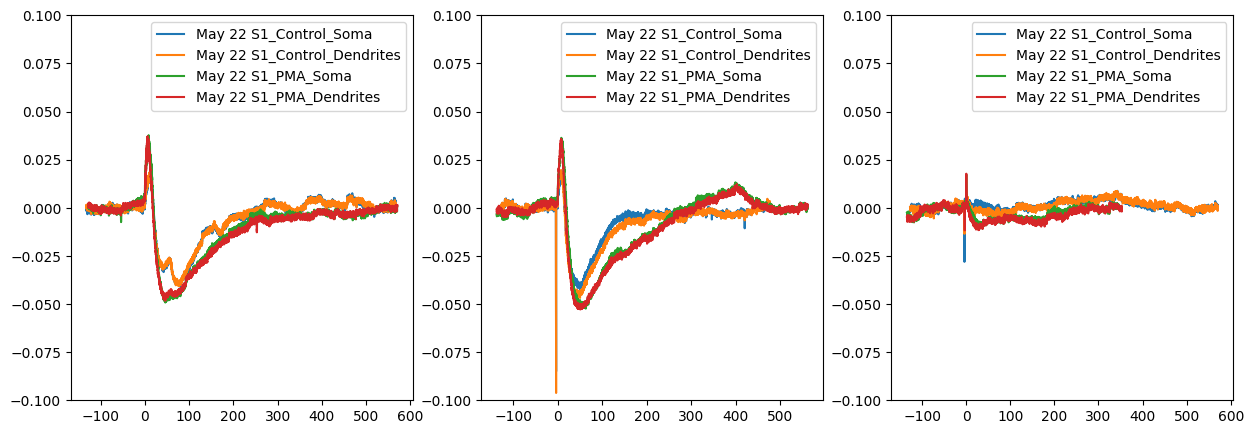

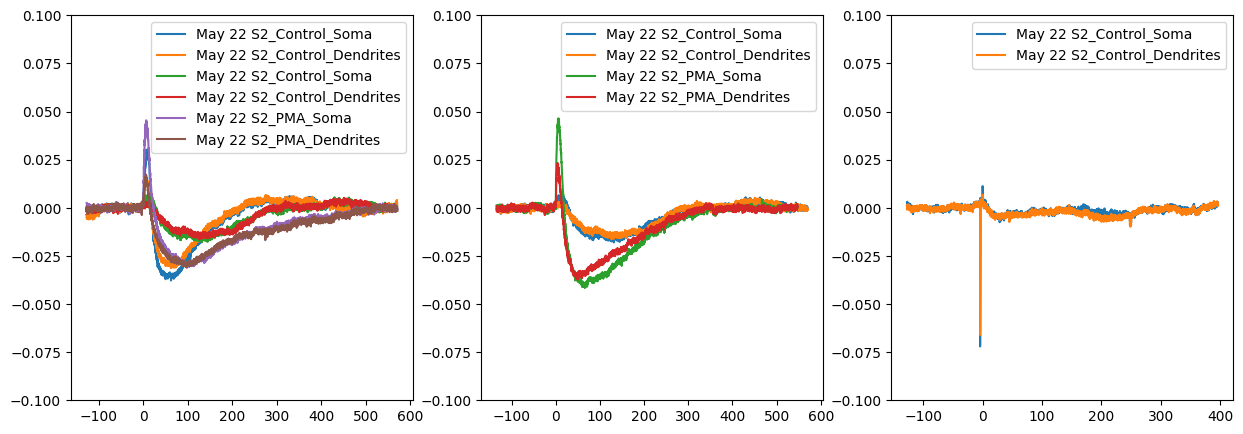

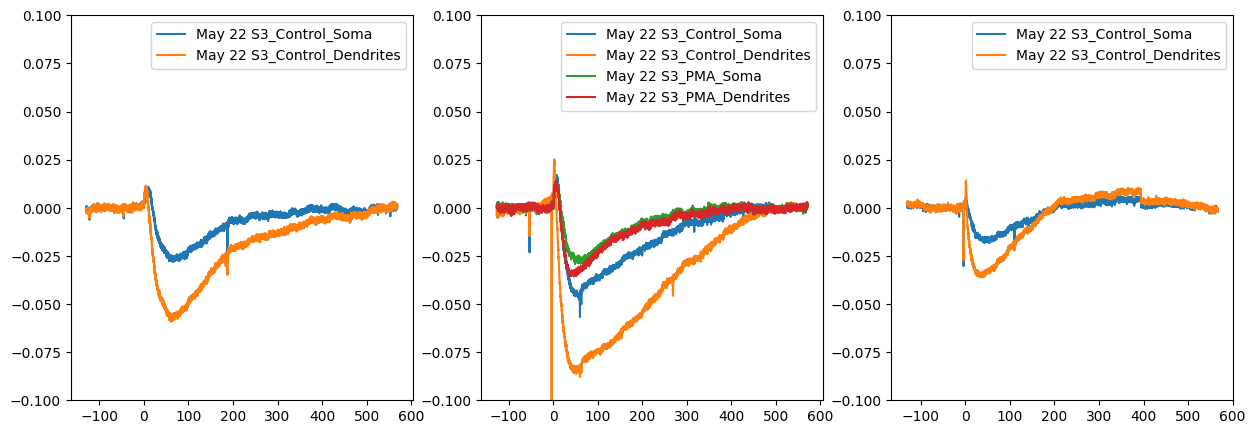

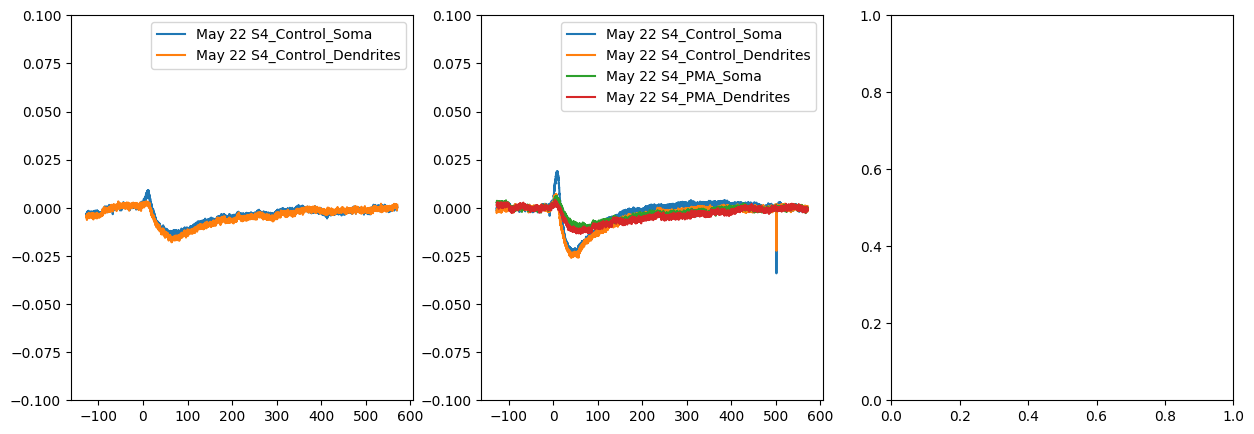

In [8]:

for k,v in time_value_dict.items():
    df_val = v['values'].copy()
    df_time = v['time'].copy()
    fig,ax=plt.subplots(1,3,figsize=[15,5])
    for c in df_val.columns:
        if 'Glucose' in c[2]:
            # try:
            if '10Hz' in c[1]: axi=1
            if '5Hz' in c[1]: axi=0
            if '100Hz' in c[1]: axi=2
            trace = df_val[c]
            time = df_time[c]

            '''bleach correction'''
            start_refs_bool = np.logical_and(time<-10,time>-100) #'keep inbetween'

            has_signal = abs(z_trans(trace))<5  # 'not out of range'
            has_sig_ind = np.arange(len(has_signal))[has_signal] #'convert to indicies'
            has_sig_ind = has_sig_ind[:-20] #'trim indicies'
            has_signal = np.zeros_like(has_signal) #'init new bool array'
            has_signal[has_sig_ind] = True #'flip good inicies'
            trim_time = time[has_signal]
            end_refs_bool = np.logical_and(time>np.max(trim_time)-50,time<np.max(trim_time)) #'keep last 50s'
            ref_inds_bool = np.logical_or( start_refs_bool, end_refs_bool) #'keep both windows'
            try:
                ref_inds=np.arange(len(ref_inds_bool))[ref_inds_bool]
                trace,bc = bleach_cor(trace,ref_inds)
            except: print(ref_inds,time,k,c)


            '''DF calc'''
            df_refs =  np.logical_and(time<-10,time>-100)
            f0 = np.mean(trace[df_refs])
            df_trace = (trace-f0)/f0
            label = k+'_'+c[0]+'_'+c[3]
            ax[axi].plot(time[has_signal], df_trace[has_signal],label=label)
            ax[axi].legend()
            # ax.set_xlim(-3,None)
            ax[axi].set_ylim(-.1,.1)
            df_val[c] = df_trace
            # except: print(k,c)

    time_value_dict[k]['values']=df_val
    plt.show()
# plt.legend()

In [9]:

######## Plotting

# for k,v in time_value_dict.items():
#     df_val = v['values'].copy()
#     df_time = v['time'].copy()
#     fig,ax=plt.subplots(1,3,figsize=[15,5])
#     twix = [0,0,0]
#     for axi in range(3):
#             twix[axi] = ax[axi].twinx()
#     for c in df_val.columns:
#         if 'Control' in c[0]:
#             if '10Hz' in c[1]: axi=1
#             if '5Hz' in c[1]: axi=0
#             if '100Hz' in c[1]: axi=2


#             if 'Glucose' in c[2]:
#                 trace_v = df_val[c]
#                 trace_t = df_time[c]
#                 label = c[3]
#                 twix[axi].plot(trace_t, trace_v,label=label)
#                 twix[axi].set_ylim(-.1,.1)
#                 twix[axi].legend()
#             else:
#                 trace_v = df_val[c]
#                 trace_t = df_time[c]
#                 label = c[3]
#                 ax[axi].plot(trace_t, trace_v,label=label)

#                 # ax[axi].set_ylim(-.1,.1)
#                 ax[axi].set_xlim(-2,40)
#                 ax[axi].legend()

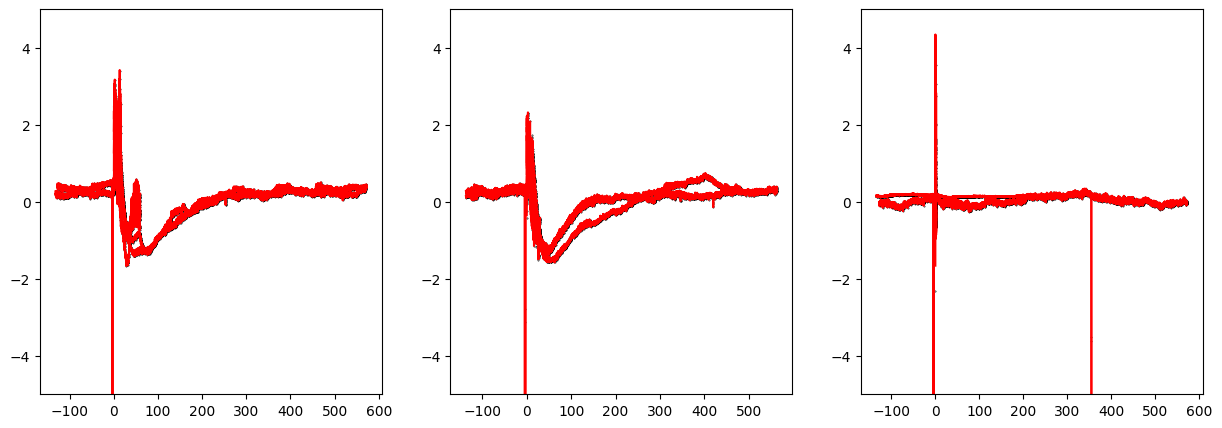

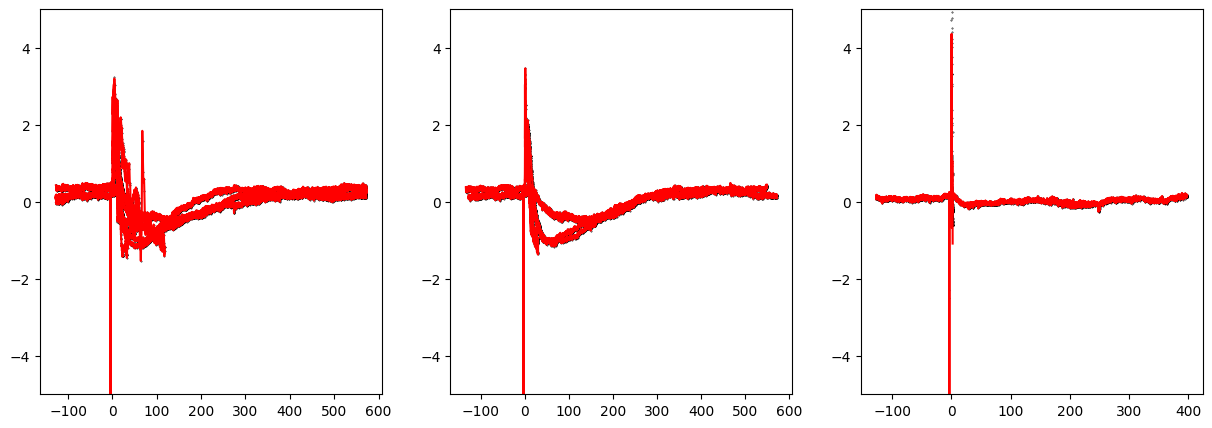

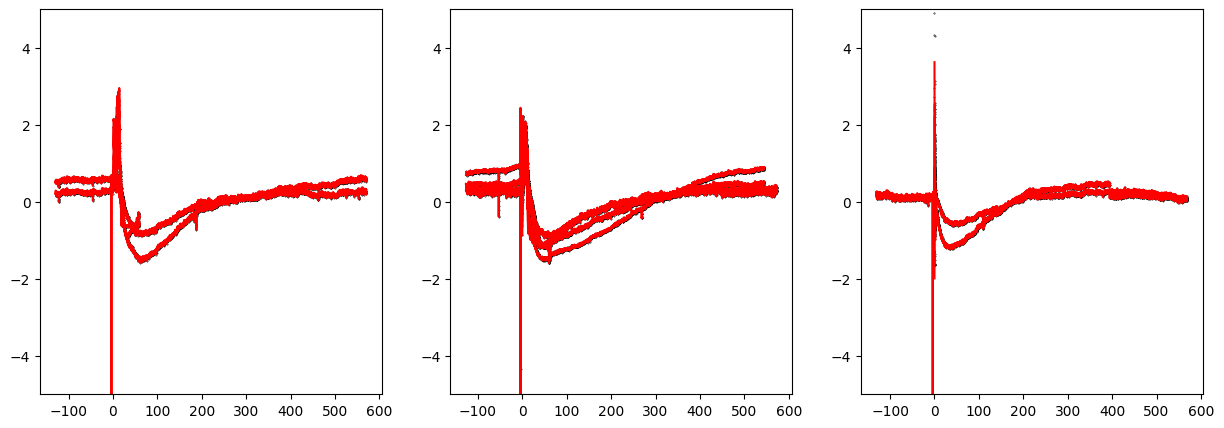

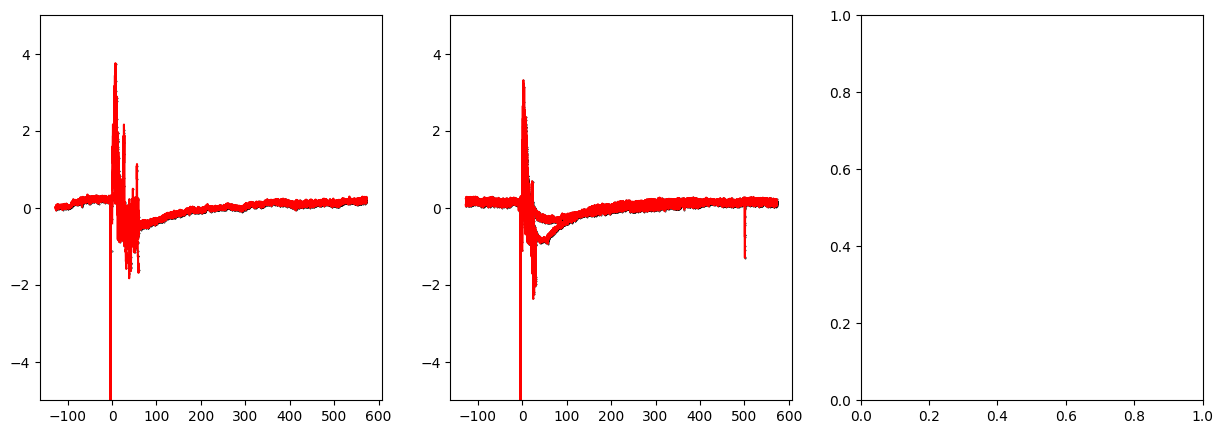

In [10]:
def upsample(y_low,fs_low,fs_high,x_low=[],x_high=[],kind='quadratic'):
    y_low_good = np.logical_not(np.isnan(y_low))
    y_low = y_low[y_low_good]
    x_low = x_low[y_low_good]
    len_low = len(y_low)
    up_ratio = fs_high/fs_low
    if len(x_low)==0: x_low=np.arange(len_low)
    if len(x_high)==0: x_high=np.arange(np.min(x_low),np.max(x_low)+1/fs_low,1/fs_high)
    interpolator = scipy.interpolate.interp1d(x_low, y_low, kind=kind)
    x_in_range = np.logical_and(  x_high<=np.max(x_low),x_high>=np.min(x_low)  )
    x_high =x_high[x_in_range]
    y_high = interpolator(x_high)
    return y_high, x_high




####### common up_sample
for k,v in time_value_dict.items():
    ups_val = v['values'].copy()
    ups_time = v['time'].copy()
    fig,ax=plt.subplots(1,3,figsize=[15,5])
    for col in ups_val.columns:
        if '10Hz' in col[1]: axi=1
        if '5Hz' in col[1]: axi=0
        if '100Hz' in col[1]: axi=2
        y_low = ups_val[col]
        x_low = ups_time[col]
        fs_high = 100
        fs_low = int(col[1].replace('Hz',""))
        x_high = ups_time[(col[0],col[1],'Glucose','Soma')]
        y_high, x_high = upsample(y_low,fs_low,fs_high,x_low=x_low,x_high=x_high,kind='quadratic')
        if len(y_high)<len(ups_val):
            'zero fill'
            y_high = np.concatenate([y_high,np.ones(len(ups_val)-len(y_high))*np.nan])
            x_high = np.concatenate([x_high,np.ones(len(ups_val)-len(x_high))*np.nan])

        ax[axi].scatter(x_low,z_trans(y_low),s=.5,marker ='.',color='k')
        ax[axi].plot(x_high,z_trans(y_high),color='r')
        ax[axi].set_ylim((-5,5))
        ups_val[col] = y_high
        ups_time[col] = x_high
    v['values'] = ups_val
    v['time'] = ups_time

In [11]:

# for k,v in time_value_dict.items():
#     ups_val = v['values'].copy()
#     ups_time = v['time'].copy()
#     fig,ax=plt.subplots(5,1,figsize=[15,8])
#     for col in ups_val.columns:
#         if 'Control' in col[0]:
#             types = ['LFP', 'PopSpike', 'Unnamed:','Soma','Dendrites']
#             col_key =
#             axi = types.index(col_key)
#             time = ups_time[col]
#             trace = ups_val[col]
#             is_ok = time>0
#             ax[axi].plot(time[is_ok],trace[is_ok], label = col )
#             # if 'Glucose' in col[2]: ax[axi].set_ylim(-0.1,0.04)
#             ax[axi].legend(loc = 'upper right')
#             ax[axi].set_xlim(-5,40)

SyntaxError: ignored

In [ ]:
import keras


In [12]:
inputs = [[],[],[]]
outputs = [[],[]]
for k,v in time_value_dict.items():
    ups_val = v['values'].copy()
    ups_time = v['time'].copy()
    for col in ups_val.columns:
        if 'Control' in col[0]:
            types = ['LFP', 'PopSpike', 'Unnamed:','Soma','Dendrites']
            types_key =  types.index( col[3].split(' ')[0])
            if types_key<=2:
                inputs[types_key].append(ups_val[col])
            else:
                outputs[types_key-3].append(ups_val[col])

In [13]:
input_shape = (,3,1000)
psf1 = (,3,10000)
psf2 = (,3,10000)
out_shape_1 = (,1,10000)
out_shape_2 = (,1,10000)

SyntaxError: ignored

(1, 91)


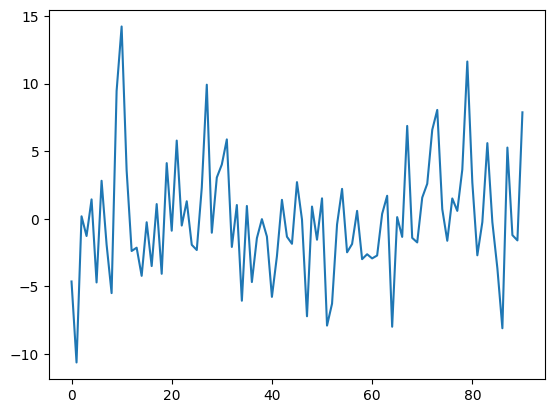

In [20]:
inp = np.random.randn(3,10)
psf = np.random.randn(3,100)
out = np.random.randn(1,100)


testout = scipy.signal.convolve2d(inp, psf, mode='valid',boundary='fill' ,fillvalue=0)
plt.plot(testout.T)
print(testout.shape)

In [147]:
def decon_err(psf_vec,x_imp,y_true,psf_shape):
    psf = np.reshape(psf_vec, psf_shape)
    y_hat = scipy.signal.convolve2d(x_imp, psf, mode='valid',boundary='fill' ,fillvalue=0)
    error = np.linalg.norm(y_true-y_hat,ord=1)
    return error

def decon_pred(psf_vec,x_imp,y_true,psf_shape):
    psf = np.reshape(psf_vec, psf_shape)
    return scipy.signal.convolve2d(x_imp, psf, mode='valid',boundary='fill' ,fillvalue=0)

def layerd_err(psf_vec,x_imp_stack,y_true_stack,psf_shape):
    num_stacks = x_imp_stack.shape[2]
    err_stack = np.ones(num_stacks)
    for s in range(num_stacks):
        x_imp=x_imp_stack[:,:,s]
        y_true = y_true_stack[:,:,s]
        err_stack[s] = decon_err(psf_vec,x_imp,y_true,psf_shape)
    pred_err = np.sum(err_stack)
    psf = np.reshape(psf_vec, psf_shape)
    print(pred_err)
    return pred_err

def solver(x_imp_stack,y_true_stack):
    psf_depth = x_imp_stack.shape[0]
    psf_len = y_true_stack.shape[1]+x_imp_stack.shape[1]-1
    psf = np.zeros((psf_depth,psf_len))
    psf_shape = psf.shape
    psf_vec = np.reshape(psf,psf_shape[0]*psf_shape[1])
    p = scipy.optimize.minimize(layerd_err, psf_vec, args=(x_imp_stack,y_true_stack,psf_shape) )
    return p, psf_shape




In [153]:
x_imp_stack = np.random.randn(3,20,50)> 1.6
psf_og = np.stack([y,y[-1::-1],y*0],axis=0)
y_true_stack=[]
for s in range(x_imp_stack.shape[2]):
    y_true_s = scipy.signal.convolve2d(x_imp_stack[:,:,s], psf_og, mode='valid',boundary='fill' ,fillvalue=0)
    y_true_stack.append(y_true_s)
y_true_stack = np.stack(y_true_stack,axis=1)



# p, psf_shape = solver(x_imp_stack,y_true_stack)
psf_hat = np.reshape(p.x,psf_shape)




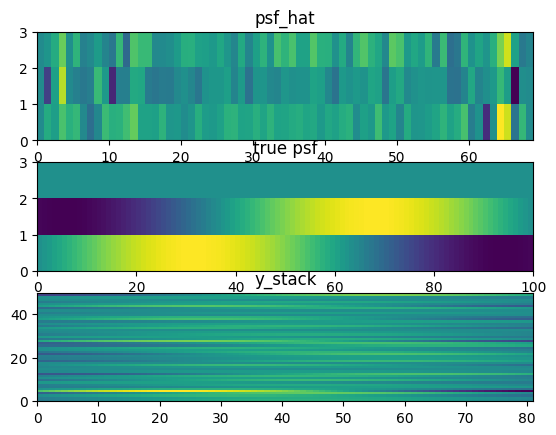

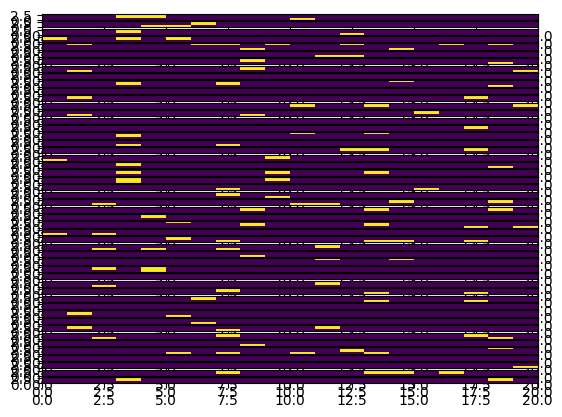

In [154]:
fig,ax=plt.subplots(3,1)
ax[0].pcolorfast(psf_hat)
ax[0].set_title('psf_hat')
ax[1].pcolorfast(psf_og)
ax[1].set_title('true psf')
ax[2].pcolorfast(y_true_stack[0,:,:])
ax[2].set_title('y_stack')
numstack = x_imp_stack.shape[2]
fig,axs=plt.subplots(numstack)
for s in range(numstack):
    axs[s].pcolorfast(x_imp_stack[:,:,s])


In [ ]:

psf_shape = psf.shape
psf_vec = np.reshape(psf,psf_shape[0]*psf_shape[1])
p = scipy.optimize.minimize(layerd_err, psf_vec, args=(x_imp_stack,y_true_stack,psf_shape) )

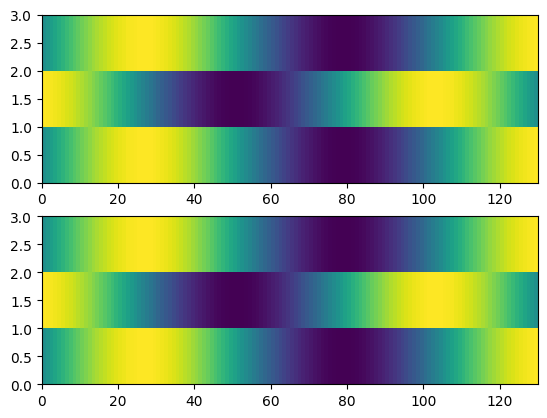

In [60]:
y_r = y[-1:0:-1]
y_r.shape

(129,)

In [ ]:
len(inputs)
for i in inputs:
    for ii in i:
        display(np.array(ii))
        # print(len(ii))

In [ ]:




# y_low = ups_val[c]
# x_low = ups_time[c]
# fs_high = 100
# fs_low = 5
# y_high, x_high = upsample(y_low,fs_low,fs_high,x_low=x_low,kind='quadratic') #,x_high=x_high

# fig,ax=plt.subplots(2,1,figsize=(15,3))
# ax[0].scatter(x_low,y_low)
# ax[0].scatter(x_high,y_high,3,color='m')


# y_low = ups_val[(c[0],c[1],'Glucose','Soma')]
# x_low = ups_time[(c[0],c[1],'Glucose','Soma')]
# fs_high = 100
# fs_low = 10
# y_high, x_high = upsample(y_low,fs_low,fs_high,x_low=x_low,kind='linear') #,x_high=x_high

# ax[1].scatter(x_low,y_low)
# ax[1].scatter(x_high,y_high,3,color='m')
# ax[1].set_ylim(-.02,.02)




In [ ]:
for k,v in time_value_dict.items():
    ups_val = v['values'].copy()
    ups_time = v['time'].copy()
    fig,ax=plt.subplots(1,3,figsize=[15,5])
    for c in ups_val.columns:
        if '10Hz' in c[1]: axi=1
        if '5Hz' in c[1]: axi=0
        if '100Hz' in c[1]: axi=2
        if '5Hz' in c[1] and ('Integrals' in c[2] or 'fEPSP' in c[2]):
            y_low = ups_val[c]
            x_low = ups_time[c]
            fs_high = 10
            fs_low = 5
            c_other = (c[0],c[1],'Glucose','Soma')
            x_high = ups_time[c_other]
            y_high, x_high = upsample(y_low,fs_low,fs_high,x_low=x_low,x_high=x_high,kind='quadratic')

            if len(y_high)<len(ups_val):
                'nan fill'
                y_high = np.concatenate([y_high,np.ones(len(ups_val)-len(y_high))*np.nan])
                x_high = np.concatenate([x_high,np.ones(len(ups_val)-len(x_high))*np.nan])
            ax[axi].scatter(x_low,y_low,s=0.1,marker ='.',color='k')
            ax[axi].scatter(x_high,y_high,s=0.1,marker ='.',color='r')
            ups_val[c] = y_high
            ups_time[c] = x_high
        if '100Hz' in c[1] and 'Glucose' in c[2]:
            y_low = ups_val[c]
            x_low = ups_time[c]
            fs_high = 100
            fs_low = 10
            c_other = (c[0],c[1],'Integrals','LFP')
            x_high = ups_time[c_other]
            y_high, x_high = upsample(y_low,fs_low,fs_high,x_low=x_low,x_high=[],kind='quadratic')
            if len(x_high)>len(ups_val):
                'nan fill new dataframe'
                dl = len(x_high)-len(ups_val)
                new_ind = np.arange(dl)+len(ups_val)+1
                nan_pd = pd.DataFrame( data=np.nan*np.ones((dl,len(ups_val.columns))), index=new_ind, columns=ups_val.columns)
                ups_val = pd.concat([ups_val,nan_pd],axis =0,join='outer')
                ups_time = pd.concat([ups_time,nan_pd],axis =0,join='outer')
            if len(y_high)<len(ups_val):
                'nan fill new trace'
                y_high = np.concatenate([y_high,np.ones(len(ups_val)-len(y_high))*np.nan])
                x_high = np.concatenate([x_high,np.ones(len(ups_val)-len(x_high))*np.nan])
            ups_val[c] = y_high
            ups_time[c] = x_high
            ax[axi].scatter(x_low,y_low,s=0.1,marker ='.',color='k')
            ax[axi].scatter(x_high,y_high,s=0.1,marker ='.',color='r')
            ax[axi].set_ylim(-0.1,0.1)
    time_value_dict[k] = {'values':ups_val, 'time':ups_time}

In [ ]:
time_value_dict['May 22 S1']['values'].keys()

impulse_trace_label = ('Control', '10Hz', 'Integrals', 'PopSpike')
folower_trace_label = ('Control', '10Hz', 'Glucose', 'Soma')

fig,ax=plt.subplots(4,1,figsize=(15,6))
impulse_trace_time = time_value_dict['May 22 S1']['time'][impulse_trace_label]
impulse_trace = time_value_dict['May 22 S1']['values'][impulse_trace_label]
impulse_trace[np.isnan(impulse_trace)]=0
impulse_trace[impulse_trace<0]=0
ax[0].plot(impulse_trace_time,impulse_trace)

folower_trace_time = time_value_dict['May 22 S1']['time'][folower_trace_label]
folower_trace = time_value_dict['May 22 S1']['values'][folower_trace_label]

folower_trace[folower_trace_time<=0]=0


folower_trace[np.isnan(folower_trace)]=0
ax[1].plot(folower_trace_time,folower_trace)


func = np.zeros_like(folower_trace).astype('float64')
x1 =800
x2 = 5000
func[:x1]=1
func[x1:x2]=-1
func = func
ax[2].plot(folower_trace_time,func)


pred = np.dot(impulse_trace,func)
ax[3].plot(pred)